In [ ]:
# The goal is to reliably predict the retailer name based on receipt ocr raw textual data. 
# The raw retailer name comes on the `establishment` inside the `rawData` field. 
# The values in `establishment` may came in different flavors (i.e. Boots vs Boots UK) and 
# we want that the predicted value be unique (Boots).



In [3]:
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import utils
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.preprocessing import text
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_colwidth = 10000

In [6]:
# read provided dataset
df = pd.read_csv("../receipt_data.csv")
df.head(1)

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
0,NaN,GBP,2019-06-15 17:00:57,2019-06-14 18:20:00,REVIEWED,2019-06-14 22:11:40,0.7,NaN,2019-06-15 17:00:57,NaN,NaN,NaN,Selfridges,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/5955cc32-894b-4dbd-8c1f-f54fbd95d8e8


In [8]:
# filter retailerName to be used as label and rawData as features
df = df.filter(['retailerName', 'rawData'])
df.head(5)

,retailerName,rawData
0,Selfridges,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}"
1,Harrods,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Harrods"",""validatedEstablishment"":false,""date"":""2019-06-19 13:24:00"",""total"":86.000,""url"":""harrods.com"",""phoneNumber"":""020 7730 1234"",""paymentMethod"":"""",""address"":""LONDON S1 ot Road"",""validatedTotal"":false,""subTotal"":86.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.6,""totalConfidence"":0.0,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""Rewards 0005708615 Saving FRAGRANCE"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Saving FRAGRANCE f8.60"",""lineTotal"":86.000,""productCode"":""0005708615""}],""summaryItems"":[{""qty"":0,""desc"":""Sub Total"",""unit"":"""",""price"":0.000,""descClean"":""Sub Total"",""lineTotal"":86.000,""productCode"":""""},{""qty"":1,""desc"":""TOTAL ( 1 item )"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL ( item )"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Chinese Mobile Tendered"",""unit"":"""",""price"":0.000,""descClean"":""Chinese Mobile Tendered"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Rewards Points balance"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Points balance"",""lineTotal"":194.800,""productCode"":""""}]}}"
2,Boots,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Boots"",""validatedEstablishment"":false,""date"":""2019-06-18 18:24:00"",""total"":20.460,""url"":"""",""phoneNumber"":""(0115) 9410199"",""paymentMethod"":"""",""address"":"""",""validatedTotal"":true,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""50.500"",""change"":""30.040"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.99,""cashConfidence"":0.99,""changeConfidence"":0.99,""roundingConfidence"":0.0,""otherData"":[""f"",""Boots UK Limited"",""NOTTINGHAM - 6"",""18/06/2019"",""(0115) 9410199"",""18:24"",""Served by: LAURIEN GOOD"",""1404"",""619 7646 0006 144 *6330******

In [9]:
# we can see that some Boot tags are duplicated
df['retailerName'].value_counts()

Selfridges           1961
Boots                1601
Harrods              1188
Holland & Barrett     582
John Lewis            458
TK Maxx               433
Debenhams             394
Boots UK Limited      383
Name: retailerName, dtype: int64

In [10]:
# clean some data with bad labels
df.retailerName = df.retailerName.str.replace('Boots.*', 'Boots', regex=True)

# Boot retailer tags must be now deduplicated
# The counts should be closer for the model be more balanced
df['retailerName'].value_counts()

Boots                1984
Selfridges           1961
Harrods              1188
Holland & Barrett     582
John Lewis            458
TK Maxx               433
Debenhams             394
Name: retailerName, dtype: int64

In [11]:
ignore = df[df.rawData.apply(lambda x: not isinstance(x, str))]
ignore.head(5)

,retailerName,rawData
685,Boots,NaN
1326,Boots,NaN
1537,John Lewis,NaN
1872,Holland & Barrett,NaN
3050,Boots,NaN


In [12]:
# drop rows with empty or not string rawData 
dfc = df[df.rawData.apply(lambda x: isinstance(x, str))]
dfc.head(5)

,retailerName,rawData
0,Selfridges,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}"
1,Harrods,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Harrods"",""validatedEstablishment"":false,""date"":""2019-06-19 13:24:00"",""total"":86.000,""url"":""harrods.com"",""phoneNumber"":""020 7730 1234"",""paymentMethod"":"""",""address"":""LONDON S1 ot Road"",""validatedTotal"":false,""subTotal"":86.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.6,""totalConfidence"":0.0,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""Rewards 0005708615 Saving FRAGRANCE"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Saving FRAGRANCE f8.60"",""lineTotal"":86.000,""productCode"":""0005708615""}],""summaryItems"":[{""qty"":0,""desc"":""Sub Total"",""unit"":"""",""price"":0.000,""descClean"":""Sub Total"",""lineTotal"":86.000,""productCode"":""""},{""qty"":1,""desc"":""TOTAL ( 1 item )"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL ( item )"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Chinese Mobile Tendered"",""unit"":"""",""price"":0.000,""descClean"":""Chinese Mobile Tendered"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Rewards Points balance"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Points balance"",""lineTotal"":194.800,""productCode"":""""}]}}"
2,Boots,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Boots"",""validatedEstablishment"":false,""date"":""2019-06-18 18:24:00"",""total"":20.460,""url"":"""",""phoneNumber"":""(0115) 9410199"",""paymentMethod"":"""",""address"":"""",""validatedTotal"":true,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""50.500"",""change"":""30.040"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.99,""cashConfidence"":0.99,""changeConfidence"":0.99,""roundingConfidence"":0.0,""otherData"":[""f"",""Boots UK Limited"",""NOTTINGHAM - 6"",""18/06/2019"",""(0115) 9410199"",""18:24"",""Served by: LAURIEN GOOD"",""1404"",""619 7646 0006 144 *6330******

In [13]:
rawData = dfc.rawData
parsedRawData = rawData.apply(json.loads).apply(pd.Series)
parsedRawData.head(2)

,message,status,status_code,token,success,code,duplicate,duplicateToken,result
0,SUCCESS: Result available,done,3,None,True,202,False,None,"{'establishment': 'Selfridges', 'validatedEstablishment': False, 'date': '2019-06-14 18:20:00', 'total': 30.0, 'url': 'www.selfridges.com', 'phoneNumber': '8569 4004156', 'paymentMethod': 'VISA', 'address': '400 Oxford Street London W1A 1AB', 'validatedTotal': False, 'subTotal': 30.0, 'validatedSubTotal': True, 'cash': '0.000', 'change': '0.000', 'tax': 0.0, 'discount': 0.0, 'subTotalConfidence': 0.99, 'totalConfidence': 0.7, 'cashConfidence': 0.0, 'changeConfidence': 0.0, 'roundingConfidence': 0.0, 'otherData': [], 'lineItems': [{'qty': 0, 'desc': 'FULTON BROLLYMA41568569 400415685692', 'unit': '', 'price': 0.0, 'descClean': 'You 193 were served by : Ines FULTON BROLLYMA 400415685692', 'lineTotal': 18.0, 'productCode': '41568569'}, {'qty': 0, 'desc': 'JJ DOT HYDR - TRA 82401412', 'unit': '', 'price': 0.0, 'descClean': 'JJ DOT HYDR - TRA', 'lineTotal': 12.0, 'productCode': '82401412'}], 'summaryItems': [{'qty': 2, 'desc': 'Total 2 Items', 'unit': '', 'price': 0.0, 'descClean': 'Total Items', 'lineTotal': 30.0, 'productCode': ''}, {'qty': 0, 'desc': 'Visa', 'unit': '', 'price': 0.0, 'descClean': 'Visa', 'lineTotal': 30.0, 'productCode': ''}, {'qty': 14, 'desc': '009999 Date 14 / 06 / 19', 'unit': '', 'price': 0.0, 'descClean': 'Date / 06 / 19', 'lineTotal': 18.2, 'productCode': '009999'}]}"
1,SUCCESS: Result available,done,3,None,True,202,False,None,"{'establishment': 'Harrods', 'validatedEstablishment': False, 'date': '2019-06-19 13:24:00', 'total': 86.0, 'url': 'harrods.com', 'phoneNumber': '020 7730 1234', 'paymentMethod': '', 'address': 'LONDON S1 ot Road', 'validatedTotal': False, 'subTotal': 86.0, 'validatedSubTotal': True, 'cash': '0.000', 'change': '0.000', 'tax': 0.0, 'discount': 0.0, 'subTotalConfidence': 0.6, 'totalConfidence': 0.0, 'cashConfidence': 0.0, 'changeConfidence': 0.0, 'roundingConfidence': 0.0, 'otherData': [], 'lineItems': [{'qty': 0, 'desc': 'Rewards 0005708615 Saving FRAGRANCE', 'unit': '', 'price': 0.0, 'descClean': 'Rewards Saving FRAGRANCE f8.60', 'lineTotal': 86.0, 'productCode': '0005708615'}], 'summaryItems': [{'qty': 0, 'desc': 'Sub Total', 'unit': '', 'price': 0.0, 'descClean': 'Sub Total', 'lineTotal': 86.0, 'productCode': ''}, {'qty': 1, 'desc': 'TOTAL ( 1 item )', 'unit': '', 'price': 0.0, 'descClean': 'TOTAL ( item )', 'lineTotal': 77.4, 'productCode': ''}, {'qty': 0, 'desc': 'Chinese Mobile Tendered', 'unit': '', 'price': 0.0, 'descClean': 'Chinese Mobile Tendered', 'lineTotal': 77.4, 'productCode': ''}, {'qty': 0, 'desc': 'Rewards Points balance', 'unit': '', 'price': 0.0, 'descClean': 'Rewards Points balance', 'lineTotal': 194.8, 'productCode': ''}]}"


In [14]:
joined = df.join(parsedRawData)
data = joined.filter(['retailerName', 'result'])

In [15]:
# parse json result field and add columns to dataframe
parsedResult = data.result.apply(pd.Series)
joined = df.join(parsedResult)

# filter so that we get only features and labels to train the model
data = joined.filter(['establishment', 'retailerName'])
data.head(5)

,establishment,retailerName
0,Selfridges,Selfridges
1,Harrods,Harrods
2,Boots,Boots
3,Selfridges,Selfridges
4,John Lewis,John Lewis


In [16]:
ignore = data[data.establishment.apply(lambda x: not isinstance(x, str))]
ignore.head(2)

,establishment,retailerName
685,NaN,Boots
1326,NaN,Boots


In [17]:
ignore = data[data.retailerName.apply(lambda x: not isinstance(x, str))]
ignore.head(2)

,establishment,retailerName


In [18]:
data = data[data.establishment.apply(lambda x: isinstance(x, str))]
# data = data[data.retailerName.apply(lambda x: isinstance(x, str))]
data.head(10)

,establishment,retailerName
0,Selfridges,Selfridges
1,Harrods,Harrods
2,Boots,Boots
3,Selfridges,Selfridges
4,John Lewis,John Lewis
5,Selfridges,Selfridges
6,HOLLAND & BARRETT,Holland & Barrett
7,Selfridges,Selfridges
8,Selfridges,Selfridges
9,John Lewis,John Lewis


In [19]:
# get train and test dataset
train_size = int(len(data) * .8)
train_ocr = data['establishment'][:train_size]
train_tags = data['retailerName'][:train_size]
test_ocr = data['establishment'][train_size:]
test_tags = data['retailerName'][train_size:]

test_tags.size, train_size, len(data)

(1397, 5585, 6982)

In [20]:
train_ocr.head(10)

0           Selfridges
1              Harrods
2                Boots
3           Selfridges
4           John Lewis
5           Selfridges
6    HOLLAND & BARRETT
7           Selfridges
8           Selfridges
9           John Lewis
Name: establishment, dtype: object

In [21]:
# use bag of words model
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_ocr)

In [22]:
x_train = tokenize.texts_to_matrix(train_ocr)
x_test = tokenize.texts_to_matrix(test_ocr)

# x_train[0]

In [23]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

y_test

array([1, 6, 5, ..., 2, 5, 5])

In [24]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)
y_test_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [25]:
# Inspect the dimensions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train_cat shape:', y_train_cat.shape)
print('y_test_cat shape:', y_test_cat.shape)

x_train shape: (5585, 1000)
x_test shape: (1397, 1000)
y_train_cat shape: (5585, 7)
y_test_cat shape: (1397, 7)


In [26]:
batch_size = 32
epochs = 4

In [27]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
# train the model
history = model.fit(x_train, y_train_cat,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 5026 samples, validate on 559 samples
Epoch 1/4
5026/5026 [==============================] - 5s 949us/step - loss: 0.5991 - acc: 0.9357 - val_loss: 0.0805 - val_acc: 0.9821
Epoch 2/4
5026/5026 [==============================] - 3s 640us/step - loss: 0.0801 - acc: 0.9811 - val_loss: 0.0492 - val_acc: 0.9857
Epoch 3/4
5026/5026 [==============================] - 3s 657us/step - loss: 0.0478 - acc: 0.9922 - val_loss: 0.0428 - val_acc: 0.9857
Epoch 4/4
5026/5026 [==============================] - 3s 681us/step - loss: 0.0313 - acc: 0.9966 - val_loss: 0.0422 - val_acc: 0.9857


In [29]:
# evaluate the accuracy
score = model.evaluate(x_test, y_test_cat, batch_size=batch_size, verbose=1)
print('Test accuracy: {0:.2f}%'.format(score[1] * 100))

1397/1397 [==============================] - 0s 111us/step
Test accuracy: 97.28%


In [30]:
text_labels = encoder.classes_ 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_ocr.iloc[i][:50], "...")
    print('correct:' + test_tags.iloc[i])
    print("predicted: " + predicted_label + "\n")

Debelum ...
correct:Debenhams
predicted: Debenhams

TK Maxx ...
correct:TK Maxx
predicted: TK Maxx

Selfridges ...
correct:Selfridges
predicted: Selfridges

JOHN LEWIS ...
correct:John Lewis
predicted: John Lewis

Boots ...
correct:Boots
predicted: Boots

Boots ...
correct:Boots
predicted: Boots

Harrods ...
correct:Harrods
predicted: Harrods

Selfridges ...
correct:Selfridges
predicted: Selfridges

Debenhams ...
correct:Debenhams
predicted: Debenhams

HOLLAND & BARRETT ...
correct:Holland & Barrett
predicted: Holland & Barrett



In [31]:
encoder.classes_

array(['Boots', 'Debenhams', 'Harrods', 'Holland & Barrett', 'John Lewis',
       'Selfridges', 'TK Maxx'], dtype=object)

In [32]:
encoder.classes_
matrix = tokenize.texts_to_matrix(['TK UK'])
prediction = model.predict(np.array([matrix[0]]))
predicted_label = text_labels[np.argmax(prediction)]
print("predict:{0}\nindex:{1} \nlabel:{2}".format(prediction, np.argmax(prediction), predicted_label))

predict:[[0.02832553 0.01754582 0.00427536 0.02878327 0.01895206 0.0049336
  0.8971843 ]]
index:6 
label:TK Maxx


In [33]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test_cat)):
    probs = y_test_cat[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [34]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Correct label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

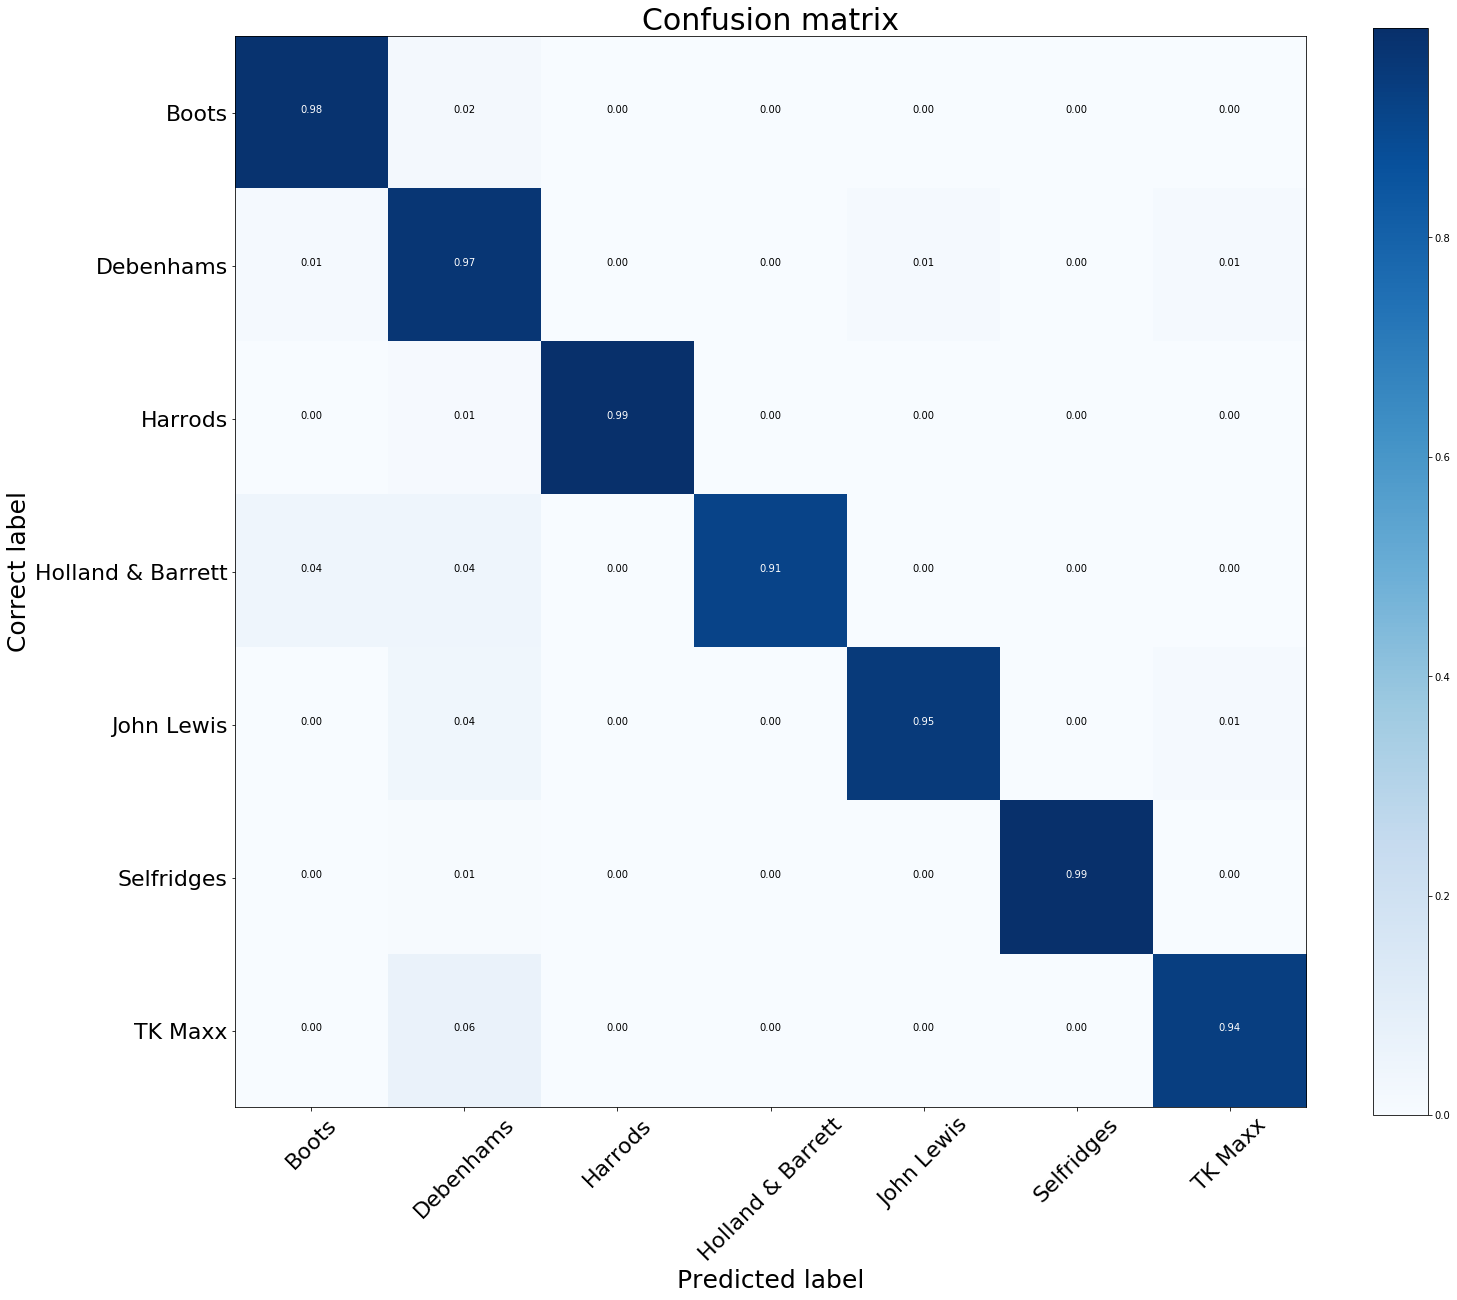

In [35]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()